In [2]:
%pylab
%matplotlib inline 
import pandas as pd
import pyecharts
import seaborn as sns
from matplotlib import patches
from scipy.spatial import ConvexHull
import warnings; warnings.simplefilter('ignore')
sns.set(style='white')
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
# df = pd.read_csv('./data/2018各省市年龄与抚养比.csv').drop('Unnamed: 0', axis=1)
# df.to_csv('./data/2018各省市年龄与抚养比.csv', index=False)

In [4]:
AR = pd.read_csv('./data/2018各省市年龄与抚养比.csv')
GDP = pd.read_csv('./data/2018各省市生产总值.csv')
MT = pd.read_csv('./data/med.csv') # 医疗水平
ED = pd.read_csv('./data/edu.csv') # 教育水平
UAR = pd.read_csv('./data/2010-2018各省市城市人口比重.csv')
SEX = pd.read_csv('./data/2018各省市性别比例.csv')
IN = pd.read_csv('./data/2018各省市工业化水平.csv')
AS = pd.read_csv('./data/2018年龄段性别比例.csv')

In [5]:
for df in [AR, GDP, MT, ED, UAR, SEX, IN]:
    df['地区'] = df['地区'].apply(lambda city: ''.join(str(city).split('  ')).strip())
#     df.set_index('地区')

In [6]:
for df in [AR, GDP, MT, ED, UAR, SEX, IN]:
    display(df.head(2))

,地区,人口数,0-14岁,15-64岁,65岁及以上,总抚养比,少年儿童抚养比,老年人口抚养比,老龄化比率
0,全国,1144648,192963,815039,136645.26,40.44,23.68,16.77,0.119378
1,北京,17673,1850,13834,1988.79,27.75,13.37,14.38,0.112533


,地区,生产总值,总值第一产业,总值第二产业,总值第三产业,人均地区生产总值,人均总值第一产业,人均总值第二产业,人均总值第三产业,地区生产总值指数,第一产业指数,第二产业指数,第三产业指数,人均地区生产总值.1
0,北京,30319.98,118.69,5647.65,24553.64,140211.241878,0.39,18.63,80.98,106.6,97.7,104.2,107.3,107.093618
1,天津,18809.64,172.71,7609.81,11027.12,120710.801930,0.92,40.46,58.62,103.6,100.1,101.0,105.9,103.710112


,地区,人口集聚度,基层医疗机构数(张),卫生机构集聚度,卫生机构比值,床位数(张),床位数集聚度,床位数比值
0,江苏,5.464,29099.0,2.967,0.54,77546.0,5.150,0.95
1,山东,4.533,72904.0,4.960,1.11,115017.0,5.096,1.14


,地区,发展指数2017,发展指数19年版,创新指数2017,创新指数19年版,绿色指数2017,绿色指数19年版,综合指数2017,综合指数19年版
0,全国,5.51,5.51,3.31,3.24,8.51,8.59,5.62,5.62
1,北京,10.00,10.00,10.00,10.00,9.93,10.00,10.00,10.00


,地区,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,全国,49.950000,51.27,52.57,53.73,54.77,56.1,57.35,58.52,59.58
1,北京,85.959455,86.20,86.20,86.30,86.35,86.5,86.50,86.50,86.50


,地区,合计,男,女
0,全国,1144648,585299,559349
1,北京,17673,8781,8892


,地区,工业化综合指数
0,北京,100
1,天津,100


In [7]:
res = AR.iloc[1:, 0]
for df in [AR[['地区', '人口数', '老年人口抚养比', '老龄化比率']], 
           GDP[['地区', '生产总值', '人均地区生产总值']], 
           MT[['地区', '卫生机构集聚度']], 
           ED[['地区', '综合指数19年版']], 
           UAR[['地区', '2018']], 
           SEX[['地区', '男','女']],
          IN[['地区', '工业化综合指数']]]:
    res = pd.merge(res, df, how='left', on='地区')
res.columns = ['地区', '总人口数', '老年人口抚养比', '老龄化比率', '生产总值', '人均地区生产总值', '医疗条件指数',
       '教育条件指数', '城镇人口比重', '男性人数', '女性人数', '工业化综合指数']
res.fillna(res['医疗条件指数'].max(), inplace=True)
res.head()

,地区,总人口数,老年人口抚养比,老龄化比率,生产总值,人均地区生产总值,医疗条件指数,教育条件指数,城镇人口比重,男性人数,女性人数,工业化综合指数
0,北京,17673,14.38,0.112533,30319.98,140211.241878,4.960,10.00,86.50,8781,8892,100
1,天津,12794,13.85,0.109182,18809.64,120710.801930,4.960,5.74,83.15,6863,5931,100
2,河北,61907,18.43,0.126871,36010.27,47772.220682,4.237,5.11,56.43,31210,30697,70
3,山西,30481,13.94,0.103259,16818.11,45328.000000,2.697,4.83,58.41,15593,14888,57
4,内蒙古,20781,12.81,0.098484,17289.22,68302.000000,0.200,4.76,62.71,10608,10174,75


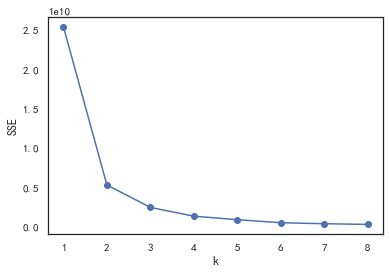

In [8]:
'''聚类分析, 根据四个指标看出分出四类最合适'''
from sklearn.cluster import KMeans

data = res[['人均地区生产总值', '医疗条件指数','教育条件指数','工业化综合指数']]

SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(data)
    SSE.append(estimator.inertia_)
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')

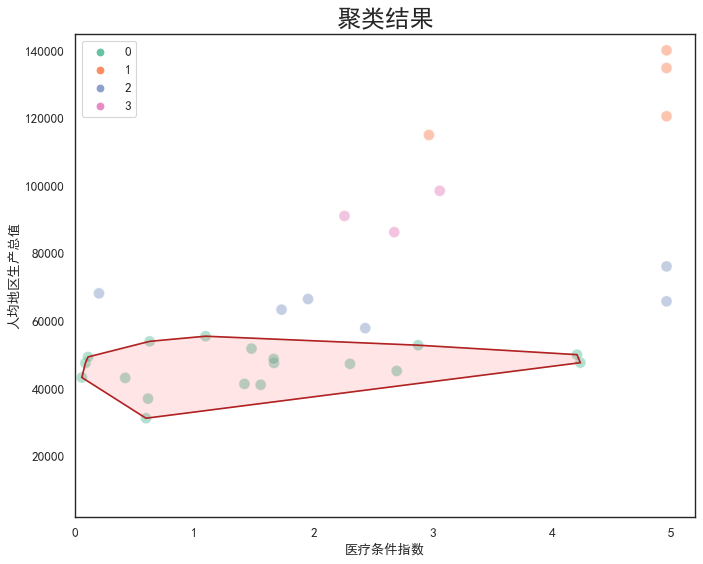

In [14]:
# 聚类可视化
estimator = KMeans(n_clusters=4)  # 构造聚类器
y_pred = estimator.fit_predict(data)

categories = set(y_pred)
colors = [plt.cm.tab10(i/float(len(categories))) for i in range(len(categories))]
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')    
sns.scatterplot(x= '医疗条件指数', y='人均地区生产总值', 
            hue=y_pred, palette="Set2", s=100, alpha=0.5,
            data=data)

# for i, category in enumerate(categories):
#     plt.scatter('医疗条件指数', '人均地区生产总值',  data=data[y_pred == categories],
#                 cmap=colors[i], label=str(category), edgecolors='black', linewidths=.5)

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

    

fc = ['red', 'gold', 'blue', 'green']    
def draw_circle(index):
    midwest_encircle_data = data[y_pred == index]                         
    encircle(midwest_encircle_data['医疗条件指数'], midwest_encircle_data['人均地区生产总值'], ec="k", fc=fc[index], alpha=0.1)
    encircle(midwest_encircle_data['医疗条件指数'], midwest_encircle_data['人均地区生产总值'], ec="firebrick", fc="none", linewidth=1.5)

    
# for index in categories:
#     draw_circle(index)
draw_circle(0) 

plt.gca().set(xlim=(0.0, 5.2), ylim=(2000, 145000),
              xlabel='医疗条件指数', ylabel='人均地区生产总值')


plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("聚类结果", fontsize=22)
plt.legend(fontsize=12)    
plt.show()  

In [15]:
res.corr()['老龄化比率'].to_frame()

,老龄化比率
总人口数,0.432813
老年人口抚养比,0.976877
老龄化比率,1.000000
生产总值,0.415584
人均地区生产总值,0.286122
医疗条件指数,0.560783
教育条件指数,0.435469
城镇人口比重,0.406100
男性人数,0.410160
女性人数,0.455762


<AxesSubplot:>

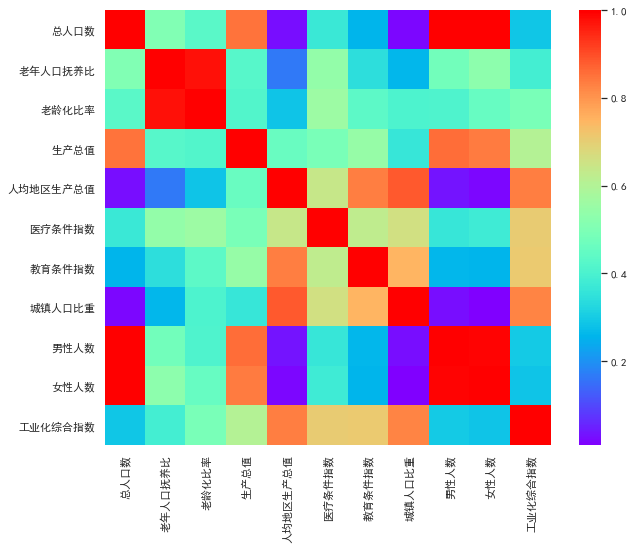

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(res.corr(), cmap='rainbow')

In [17]:
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.faker import Faker

value = SEX.iloc[0].values[2:]
value_sum = sum(value)
value = [round(v / value_sum * 10000 / 100, 2) for v in value]
label = ['男', '女']

p = (
    Pie()
    .add("", [list(z) for z in zip(label, value)])
    .set_colors(["green", "red"])
    .set_global_opts(title_opts=opts.TitleOpts(title="男女分布饼图"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    
)
p.render_notebook()

In [18]:
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.faker import Faker

value = AR.loc[AR['地区']  == '全国', [ '0-14岁', '15-64岁', '65岁及以上']].values.ravel()
value_sum = sum(value)
value = [round(v / value_sum * 10000 / 100, 2) for v in value]
label = [ '0-14岁', '15-64岁', '65岁及以上']

p = (
    Pie()
    .add("", [list(z) for z in zip(label, value)])
    .set_colors(["yellow", "red", "pink"])
    .set_global_opts(title_opts=opts.TitleOpts(title="男女分布饼图"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    
)
p.render_notebook()

In [19]:
SEX.head()

,地区,合计,男,女
0,全国,1144648,585299,559349
1,北京,17673,8781,8892
2,天津,12794,6863,5931
3,河北,61907,31210,30697
4,山西,30481,15593,14888


In [20]:
data = AR.iloc[0:, [0, 2, 3, 4]]
data = pd.merge(data, SEX.iloc[0:, [0, 2, 3]], on='地区')
data = data.iloc[0, 1:]
M = (data[:-2]  * 1.05 // 2).to_frame().reset_index()
F = (data[:-2] * 0.95 // 2 ).to_frame().reset_index()

data = pd.merge(M, F, on='index')
data.columns = ['年龄段','男', '女']
data

,年龄段,男,女
0,0-14岁,101305,91657
1,15-64岁,427895,387143
2,65岁及以上,71738,64906


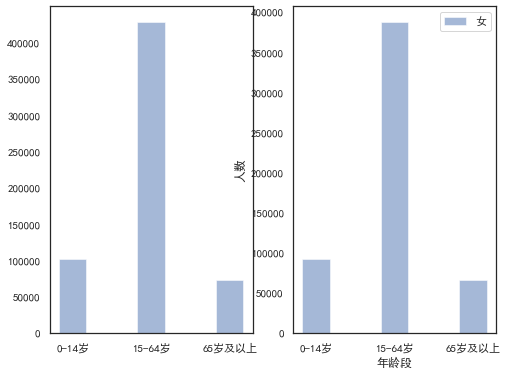

In [21]:
plt.figure(figsize=(8, 6))
X = np.array([1, 2, 3])
plt.subplot(121)
plt.bar(data['年龄段'], data['男'], alpha=0.5, width=0.35, label='男')
plt.subplot(122)
plt.bar(data['年龄段'], data['女'], alpha=0.5, width=0.35, label='女')
plt.legend()
plt.ylabel('人数')
plt.xlabel('年龄段')
plt.show()

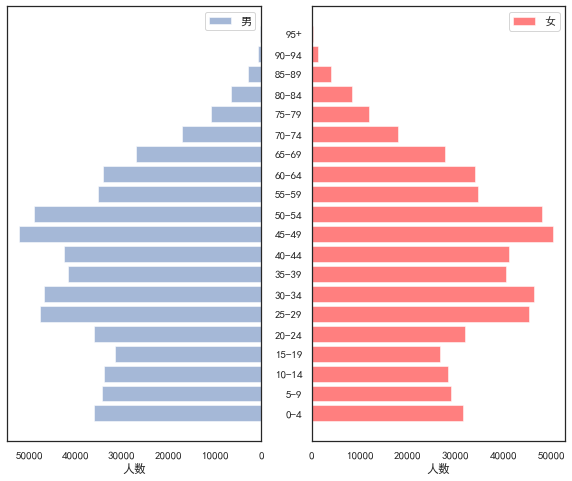

In [22]:
data = AS.iloc[1:]
plt.figure(figsize=(10, 8))
ax = plt.subplot(121)
plt.barh(data['年龄段'], data['男'], alpha=0.5, label='男')
ax.invert_xaxis()
plt.yticks([])
plt.legend()
plt.xlabel('人数')

plt.subplot(122)
plt.barh(data['年龄段'], data['女'], alpha=0.5, label='女', color='red')
plt.legend()
# plt.ylabel('人数')

plt.xlabel('人数')

plt.show()

In [23]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
y = MinMaxScaler().fit_transform(res['老龄化比率'].values.reshape(-1, 1))*225
region = res['地区']

from pyecharts import options as opts
from pyecharts.charts import Map
c = (
    Map()
    .add("老龄化程度", [list(z) for z in zip(region, y.ravel())], "china")
    .set_global_opts(title_opts=opts.TitleOpts(title="老龄化程度"),
    visualmap_opts=opts.VisualMapOpts(max_=225))
)

c.render_notebook()

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
region = GDP['地区']
gdp = MinMaxScaler().fit_transform(GDP['人均地区生产总值'].values.reshape(-1, 1))*225

from pyecharts import options as opts
from pyecharts.charts import Map
c = (
    Map()
    .add("GDP", [list(z) for z in zip(region, gdp.ravel())], "china")
    .set_global_opts(title_opts=opts.TitleOpts(title="GDP"),
    visualmap_opts=opts.VisualMapOpts(max_=225))
)

c.render_notebook()

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
region = MT['地区']
mt = MinMaxScaler().fit_transform(MT[['卫生机构集聚度', '床位数集聚度']].sum(axis=1).values.reshape(-1, 1))*225

from pyecharts import options as opts
from pyecharts.charts import Map
c = (
    Map()
    .add("医疗条件", [list(z) for z in zip(region, mt.ravel())], "china")
    .set_global_opts(title_opts=opts.TitleOpts(title="医疗条件"),
    visualmap_opts=opts.VisualMapOpts(max_=225))
)

c.render_notebook()

In [26]:
ED.head(10)

,地区,发展指数2017,发展指数19年版,创新指数2017,创新指数19年版,绿色指数2017,绿色指数19年版,综合指数2017,综合指数19年版
0,全国,5.51,5.51,3.31,3.24,8.51,8.59,5.62,5.62
1,北京,10.00,10.00,10.00,10.00,9.93,10.00,10.00,10.00
2,天津,5.75,5.63,3.39,3.17,8.69,8.97,5.81,5.74
3,河北,5.24,5.33,2.51,2.30,7.67,7.76,5.10,5.11
4,山西,4.94,4.86,1.62,1.59,8.40,8.46,4.88,4.83
5,内蒙古,4.80,4.70,1.77,1.76,8.24,8.37,4.80,4.76
6,辽宁,5.51,5.58,3.06,2.67,8.79,8.89,5.61,5.58
7,吉林,5.29,5.24,3.00,2.54,8.58,8.58,5.44,5.29
8,黑龙江,5.27,5.27,2.80,2.75,8.14,8.25,5.29,5.29
9,上海,7.57,7.75,5.66,6.28,10.00,9.90,7.63,7.85


In [27]:
ED[['综合指数19年版']].describe()

,综合指数19年版
count,32.000000
mean,5.611562
std,1.136679
min,4.290000
25%,4.860000
50%,5.380000
75%,5.930000
max,10.000000


In [28]:
from pyecharts.charts import Geo
from pyecharts.globals import GeoType
from pyecharts import options as opts
regions = ['北京','上海','天津','重庆','广州','深圳','杭州','南京','成都','武汉','西安','郑州','厦门']
values = [94, 98, 76, 89, 65, 64, 56, 59, 45, 23, 22, 22, 21]#随便输入的数据
c = (
Geo().add_schema(maptype="china").add(
    "geo", zip(regions, values), type_ = GeoType.EFFECT_SCATTER
).set_series_opts(
    label_opts=opts.LabelOpts(is_show=False)
).set_global_opts(
    visualmap_opts=opts.VisualMapOpts(is_piecewise=True),
        title_opts=opts.TitleOpts(title="Geo涟漪图"))
)
c.render_notebook()

In [29]:
GDP.describe()

,生产总值,总值第一产业,总值第二产业,总值第三产业,人均地区生产总值,人均总值第一产业,人均总值第二产业,人均总值第三产业,地区生产总值指数,第一产业指数,第二产业指数,第三产业指数,人均地区生产总值.1
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,29506.692258,2088.199016,12139.378065,15279.115177,65253.539915,8.658065,39.900000,51.439355,106.906452,103.025806,106.245161,107.958065,106.259793
std,23905.147349,1422.781058,10624.599611,12653.752468,29121.596804,4.761462,7.179021,7.739348,1.349552,2.504791,3.168684,1.543972,1.186362
min,1477.630000,104.370000,628.370000,719.010000,31336.125161,0.320000,18.630000,42.700000,103.600000,93.100000,101.000000,104.100000,103.710112
25%,15718.120000,960.707400,5701.595000,7963.920000,47561.699114,6.560000,39.140000,46.365000,106.200000,102.750000,104.250000,107.100000,105.406298
50%,21984.780000,1967.010000,8328.790000,10656.125300,52948.603524,8.600000,41.830000,49.770000,106.800000,103.400000,105.900000,108.300000,106.172237
75%,36218.025000,3051.480000,15681.390000,19908.700000,72284.628350,10.510000,44.245000,53.835000,107.900000,104.100000,107.650000,109.150000,107.201140
max,97277.770000,4950.520000,41248.520000,52751.180000,140211.241878,20.700000,49.750000,80.980000,109.100000,106.900000,117.500000,110.300000,108.410592


In [30]:
GDP[['人均地区生产总值']].describe()

,人均地区生产总值
count,31.000000
mean,65253.539915
std,29121.596804
min,31336.125161
25%,47561.699114
50%,52948.603524
75%,72284.628350
max,140211.241878


In [31]:
from pyecharts.charts import Bar
from pyecharts import options as opts

# V1 版本开始支持链式调用
bar = (
    Bar()
    .add_xaxis(["衬衫", "毛衣", "领带", "裤子", "风衣", "高跟鞋", "袜子"])
    .add_yaxis("商家A", [114, 55, 27, 101, 125, 27, 105])
    .add_yaxis("商家B", [57, 134, 137, 129, 145, 60, 49])
    .set_global_opts(title_opts=opts.TitleOpts(title="某商场销售情况"))
)
bar.render_notebook()

In [83]:
order_of_bars

array(['Stage 18: 5th Purchase', 'Stage 17: 4th Purchase',
       'Stage 16: 3rd Purchase', 'Stage 15: 2nd Purchase',
       'Stage 14: 1st Successful Purchase',
       'Stage 13: Payment Successful', 'Stage 12: Payment',
       'Stage 11: Submit Order Page',
       'Stage 10: Address Verification Page',
       'Stage 09: Cart Confirmation Page',
       'Stage 08: Buy Button Clickers', 'Stage 07: Buy Button Page',
       'Stage 06: Campaign-Email Clickthroughs',
       'Stage 05: Campaign-Email Opens', 'Stage 04: Email Confirmed',
       'Stage 03: Email Signups', 'Stage 02: Unbounced Users',
       'Stage 01: Browsers'], dtype=object)

In [38]:
data = AS.iloc[1:, [0, 2, 3]]
data

,年龄段,男,女
1,0-4,35887,31506
2,5-9,34279,29043
3,10-14,33775,28473
4,15-19,31552,26706
5,20-24,36085,31965
6,25-29,47710,45268
7,30-34,46843,46358
8,35-39,41517,40370
9,40-44,42557,41017
10,45-49,52108,50276


In [ ]:
data = AS.iloc[1:]
plt.figure(figsize=(10, 8))
ax = plt.subplot(121)
plt.barh(data['年龄段'], data['男'], alpha=0.5, label='男')
ax.invert_xaxis()
plt.yticks([])
plt.legend()
plt.xlabel('人数')

plt.subplot(122)
plt.barh(data['年龄段'], data['女'], alpha=0.5, label='女', color='red')
plt.legend()
# plt.ylabel('人数')

plt.xlabel('人数')

plt.show()